In [38]:
import pandas as pd
import numpy as np
import pystan
import warnings
import tqdm

from bokeh.io import vform, output_notebook, push_notebook
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, figure, output_file, show
from bokeh.layouts import column, row, widgetbox
from sklearn import metrics
from bokeh.resources import CDN
from ipywidgets import interact
from bokeh.embed import file_html, components
from bokeh.models import Label, LabelSet, Span, FixedTicker

output_notebook()
warnings.filterwarnings("ignore")

Loading BokehJS ...

## Prepare data

In [117]:
df = pd.read_csv('data/president_general_polls_2016.csv')
polls = df[['pollster', 'grade', 'state', 'createddate', 'samplesize', 'rawpoll_trump', 'rawpoll_clinton']]
polls.createddate = pd.to_datetime(polls.createddate)

pc = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 
      'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 
      'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

nb_voters = [2074338,301694,2323579,1078548,13202158,2596173,1560640,413921,294254,8538264,3919355,437159,666290,
             5279752,2663368,1589951,1182771,1815843,2014548,724758,2734062,3184196,4780701,2950780,1285584,
             2757323,491966,804245,1016664,718700,3683638,786522,7128852,4542488,325564,5632423,1334872,1820507,
             5742040,446049,1981516,368270,2478870,7993851,1028786,301793,3888186,3172939,670438,3068434,250701]

nb_electors = [9, 3, 11, 6, 55, 9, 7, 3, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10, 3, 5, 6, 
               4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]

states = sorted(list(set(df.state.values)))
to_remove = ['U.S.', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2']
for s in to_remove: states.remove(s)
polls = polls[polls.state.isin(states)]

polls.dropna(inplace=True)
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',  'D']
polls.grade = polls.grade.apply(lambda x: 10 - grades.index(x))

polls.samplesize = polls.samplesize.astype(np.int32)
polls['trump'] = (polls.samplesize*polls.rawpoll_trump/100).astype(np.int32)
polls['clinton'] = (polls.samplesize*polls.rawpoll_clinton/100).astype(np.int32)
polls['independent'] = (polls.samplesize - (polls.clinton + polls.trump))

polls.drop_duplicates(inplace=True)

aux = polls[polls.createddate >= pd.to_datetime('2016/11/01')]
polls_b1_lw = aux.sort('grade', ascending=False).groupby('state', as_index=False).nth(list(range(1)))

aux = polls[polls.createddate > pd.to_datetime('2016/10/07')]
polls_b3_lm = aux.sort('grade', ascending=False).groupby('state', as_index=False).nth(list(range(3)))

aux = polls.copy()
polls_b3 = aux.sort('grade', ascending=False).groupby('state', as_index=False).nth(list(range(3)))

polls_all_lw = polls[polls.createddate >= pd.to_datetime('2016/11/01')]

print(len(polls_b1_lw), len(polls_b3_lm), len(polls_b3), len(polls_all_lw))

polls = {
    'best_last_week': {
        'votes': polls_b1_lw[['trump', 'clinton', 'independent']].values, 
        'states': np.array([states.index(s) for s in polls_b1_lw.state.values])
    },
    'best3_last_month': {
        'votes': polls_b3_lm[['trump', 'clinton', 'independent']].values, 
        'states': np.array([states.index(s) for s in polls_b3_lm.state.values])
    },
    'best3': {
        'votes': polls_b3[['trump', 'clinton', 'independent']].values, 
        'states': np.array([states.index(s) for s in polls_b3.state.values])
    },
    'all_last_week': {
        'votes': polls_all_lw[['trump', 'clinton', 'independent']].values, 
        'states': np.array([states.index(s) for s in polls_all_lw.state.values])
    }
}

51 153 153 808


# Model

In [79]:
code = '''
data {
    int nb_polls;
    int nb_states;
    int nb_candidates;
    int polls_states[nb_polls];
    int votes[nb_polls, nb_candidates];
    int nb_voters[nb_states];
    real bias;
}
parameters {
    simplex[nb_candidates] theta[nb_states]; //1 - trump, 2 - clinton, 3 - independent
    vector[nb_candidates] alpha;
}
model {
    for(c in 1:nb_candidates)
        alpha[c] ~ uniform(0, 1000);

    for(s in 1:nb_states)
        theta[s] ~ dirichlet(alpha); 
        
    for(p in 1:nb_polls)
        votes[p] ~ multinomial(theta[polls_states[p]]);
}
generated quantities {
    int votes_pred[nb_states, nb_candidates];
    real epsilon[nb_states];
    simplex[nb_candidates] theta_bias[nb_states];
    real delta_t[nb_states];
    real delta_h[nb_states];
    real delta[nb_states];

    for(s in 1:nb_states) {
        if(bias == 0.0)
            epsilon[s] <- 0.0;
        else
            epsilon[s] <- uniform_rng(0, bias);
            
        delta_t[s] <- fabs(theta[s][1] - fmax(0.0, fmin(1.0, theta[s][1] + epsilon[s])));
        delta_h[s] <- fabs(theta[s][2] - fmin(1.0, fmax(0.0, theta[s][2] - epsilon[s])));
        delta[s] <- fmin(delta_t[s], delta_h[s]);
        theta_bias[s][1] <- theta[s][1] + delta[s];
        theta_bias[s][2] <- theta[s][2] - delta[s];
        theta_bias[s][3] <- theta[s][3];
        votes_pred[s] <- multinomial_rng(theta_bias[s], nb_voters[s]);
    }
}
'''

model = pystan.StanModel(model_code=code)

In [80]:
data = {
    'nb_states': 51,
    'nb_candidates': 3,
    'nb_polls': len(polls['all_last_week']['votes']),
    'polls_states': polls['all_last_week']['states']+1,
    'votes': polls['all_last_week']['votes'],
    'nb_voters': nb_voters,
    'bias': 0.0,
}

fit = model.sampling(data=data, iter=10000, chains=4, thin=2, seed=0)

In [81]:
trace = fit.extract()

In [82]:
np.save('data/trace_all_last_week.npy', trace)

<IPython.core.display.Javascript object>


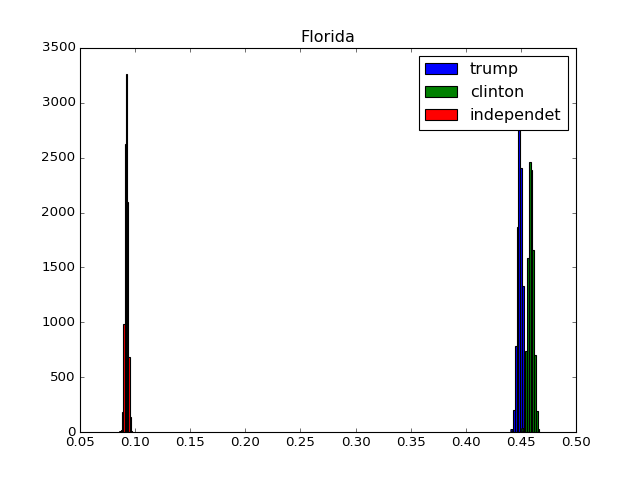

In [69]:
# p = figure(title="Bias influence", plot_height=400, plot_width=550, x_range=(0, 5), y_range=(0, 100))
# p.line(bias_prob[:, 0]*100, bias_prob[:, 2]*100, line_width=3, color='red', legend='Trump')
# p.line(bias_prob[:, 0]*100, bias_prob[:, 3]*100, line_width=3, color='blue', legend='Clinton')
# p.line(bias_prob[:, 0]*100, bias_prob[:, 1]*100, line_width=3, color='green', legend='Others')


# intersec = Span(location=1.54215, dimension='height', line_color='black', line_dash='dashed', line_width=1)
# p.add_layout(intersec)
# p.legend.location = 'right_center'
# p.xaxis[0].axis_label = 'Trump favorable bias'
# p.yaxis[0].axis_label = 'Probability of winning'
# p.xaxis[0].ticker=FixedTicker(ticks=np.array([0, 0.01, 0.0154, 0.02, 0.03, 0.04, 0.05])*100)
# show(p)


plt.figure()
s = 9 # Florida
plt.hist(trace['theta'][:, s, 0], label='trump')
plt.hist(trace['theta'][:, s, 1], label='clinton')
plt.hist(trace['theta'][:, s, 2], label='independet')
plt.title(sorted(list(states))[s])
plt.legend()

<IPython.core.display.Javascript object>


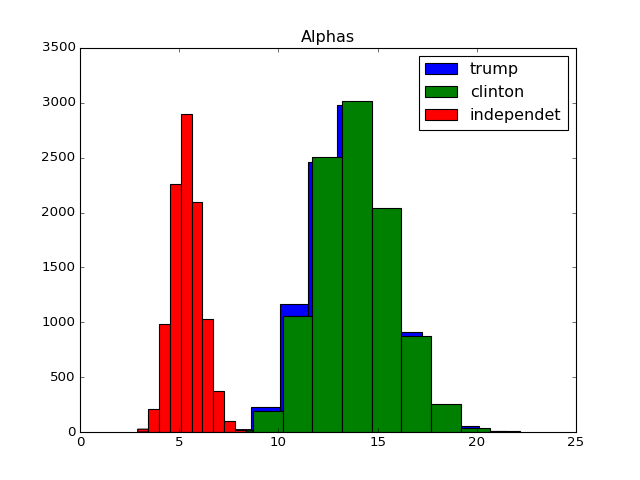

In [70]:
plt.figure()
plt.hist(trace['alpha'][:, 0], label='trump')
plt.hist(trace['alpha'][:, 1], label='clinton')
plt.hist(trace['alpha'][:, 2], label='independet')
plt.title("Alphas")
plt.legend()

In [73]:
#trace_lw = np.load('data/trace_best_last_week.npy').item()

In [93]:
votes_pred = trace['votes_pred']

In [94]:
winners = []
for election_sample in votes_pred:
    cnts = np.zeros(3)
    for s, tci in enumerate(election_sample):
        cnts[tci.argmax()] += nb_electors[s]
    if cnts.max() >= 270:
        winners.append(cnts.argmax())
    else:
        winners.append(-1)

In [96]:
print(set(winners))

{1}


In [86]:
print((np.histogram(winners, bins=3)[0]/len(winners))[0]*100)
print((np.histogram(winners, bins=3)[0]/len(winners))[1]*100)
print((np.histogram(winners, bins=3)[0]/len(winners))[2]*100)

0.0
100.0
0.0


In [ ]:
biases = np.linspace(0.0, 0.05, 20)
biases_traces = []
winners = []
for b in tqdm.tqdm(biases):
    data = {
        'nb_states': 51,
        'nb_candidates': 3,
        'nb_polls': len(polls['best_last_week']['votes']),
        'polls_states': polls['best_last_week']['states']+1,
        'votes': polls['best_last_week']['votes'],
        'nb_voters': nb_voters,
        'bias': b
    }

    fit = model.sampling(data=data, iter=10000, thin=2, chains=4)
    trace = fit.extract()
    biases_traces.append(trace)
    winner = []
    for election_sample in trace['votes_pred']:
        cnts = np.zeros(3)
        for s, tci in enumerate(election_sample):
            cnts[tci.argmax()] += nb_electors[s]
        if cnts.max() >= 270:
            winner.append(cnts.argmax())
        else:
            winner.append(-1)
    winners.append(np.histogram(winner, bins=3)[0]/float(len(winner)))

np.save('data/biases.npy', biases)
np.save('data/biases_traces.npy', biases_traces)

 95%|█████████▌| 19/20 [1:17:34<04:04, 244.62s/it]

In [120]:
trace['votes_pred'].shape

(10000, 51, 3)

In [101]:
winners = np.array(winners)

In [102]:
winners.shape, biases.reshape(-1, 1).shape

((20, 3), (20, 1))

In [103]:
bias_prob = np.append(biases.reshape(-1, 1), winners, axis=1)

In [118]:
bias_prob

array([[ 0.        ,  0.0176    ,  0.1125    ,  0.8699    ],
       [ 0.00263158,  0.0253    ,  0.1389    ,  0.8358    ],
       [ 0.00526316,  0.0275    ,  0.1708    ,  0.8017    ],
       [ 0.00789474,  0.0328    ,  0.2182    ,  0.749     ],
       [ 0.01052632,  0.0326    ,  0.2686    ,  0.6988    ],
       [ 0.01315789,  0.0357    ,  0.3211    ,  0.6432    ],
       [ 0.01578947,  0.0368    ,  0.3693    ,  0.5939    ],
       [ 0.01842105,  0.0367    ,  0.4428    ,  0.5205    ],
       [ 0.02105263,  0.035     ,  0.5074    ,  0.4576    ],
       [ 0.02368421,  0.0322    ,  0.5655    ,  0.4023    ],
       [ 0.02631579,  0.0381    ,  0.6197    ,  0.3422    ],
       [ 0.02894737,  0.0333    ,  0.6793    ,  0.2874    ],
       [ 0.03157895,  0.024     ,  0.7366    ,  0.2394    ],
       [ 0.03421053,  0.0224    ,  0.7799    ,  0.1977    ],
       [ 0.03684211,  0.0196    ,  0.8254    ,  0.155     ],
       [ 0.03947368,  0.0173    ,  0.8632    ,  0.1195    ],
       [ 0.04210526,  0.

In [136]:
out = []
for i, (bias, trace) in enumerate(zip(biases, biases_traces)):
    d = {'bias': bias, 'state_probs': {}, 'state_votes': {}, 'electoral_votes': {}}
    for s, (code, state, electoral_votes) in enumerate(zip(pc, states, nb_electors)):
        count = np.zeros(3)
        for votes in trace['votes_pred'][:, s]:
            count[votes.argmax()] += 1
        d['state_probs'][code] = {
            'trump': count[0]/count.sum(),
            'clinton': count[1]/count.sum(),
            'others': count[2]/count.sum(),
        }
        
        d['state_votes'][code] = {
            'trump': trace['votes_pred'][:, s, 0].sum()/trace['votes_pred'][:, s].sum(),
            'clinton': trace['votes_pred'][:, s, 1].sum()/trace['votes_pred'][:, s].sum(),
            'others': trace['votes_pred'][:, s, 2].sum()/trace['votes_pred'][:, s].sum(),
        }
        
        d['electoral_votes'][code] = {
            'trump': int(electoral_votes*(d['state_votes'][code]['trump']>d['state_votes'][code]['clinton'])),
            'clinton': int(electoral_votes*(d['state_votes'][code]['trump']<d['state_votes'][code]['clinton'])),
        }
        
    out.append(d)

In [105]:
import numpy as np
from bokeh.io import vform, output_notebook, push_notebook
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, figure, output_file, show
from bokeh.layouts import column, row, widgetbox
from sklearn import metrics
from bokeh.resources import CDN
from ipywidgets import interact
from bokeh.embed import file_html, components
from bokeh.models import Label, LabelSet, Span, FixedTicker

output_notebook()

Loading BokehJS ...

In [115]:
p = figure(title="Polling bias influence on forecast", plot_height=400, plot_width=550, x_range=(0, 5), y_range=(0, 100))
p.line(bias_prob[:, 0]*100, bias_prob[:, 2]*100, line_width=3, color='red', legend='Trump')
p.line(bias_prob[:, 0]*100, bias_prob[:, 3]*100, line_width=3, color='blue', legend='Clinton')
p.line(bias_prob[:, 0]*100, bias_prob[:, 1]*100, line_width=3, color='green', legend='Neither')
p.title.align = 'center'

intersec = Span(location=2.004, dimension='height', line_color='black', line_dash='dashed', line_width=1)
p.add_layout(intersec)
p.legend.location = 'right_center'
p.xaxis[0].axis_label = 'Trump favorable bias (%)'
p.yaxis[0].axis_label = 'Probability of winning (%)'
#p.xaxis[0].ticker=FixedTicker(ticks=np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05])*100)
show(p)

In [ ]:
html = file_html(p, CDN, "bias")

In [ ]:
open('data/plot.html', 'w').write(html)